# Function

In [ ]:
import re 
import numpy as np 
import pandas as pd
from argparse import Namespace
import pickle 
import torch 

import sys
import os

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)
    
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from trainer import Trainer
from examples.train_and_visu_non_recurrent import get_multi_ds
from utils.metrics import evaluate_metrics

SAVE_FOLDER_PATH = f'{current_path}/save/K_fold_validation/training_with_HP_tuning'



def load_trained_model(model_args,ds,model_fold_i,folder_name):
    if folder_name != '':
        save_path = f'{SAVE_FOLDER_PATH}/{folder_name}/best_models'
    else:
        save_path = f'{SAVE_FOLDER_PATH}/best_models'
    selected_model_path = f"{save_path}/{model_fold_i}.pkl"
    
    model_param = torch.load(selected_model_path)
    args = model_args['model'][model_fold_i]['args']
    args = Namespace(**args)
    model = load_model(ds, args)
    model.load_state_dict(model_param['state_dict'])
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler)
    return trainer 

def get_metrics_from_test(trainer,ds,metric_list = ['mse','mae','mape','mase']):
    Preds,Y_true,T_labels = trainer.testing(ds.normalizer)
    dic_pred_metrics = evaluate_metrics(Preds,Y_true,metric_list)
    return dic_pred_metrics

def load_model_args(folder_name):
    '''Return the dictionnary of all the saved model. 
    dictionaries are saved in a sub-folder, that's why we need to set a 'folder_name'.

    If we want to load trained model which comes directly from the HP-tuning:
    >>> set folder_name = ''
    
     '''
    if folder_name != '':
        save_path = f'{SAVE_FOLDER_PATH}/{folder_name}/best_models'
    else:
        save_path = f'{SAVE_FOLDER_PATH}/best_models'
    model_args = pickle.load(open(f'{save_path}/model_args.pkl','rb'))   
    return model_args

def load_K_fold_datasets(model_args,model_id_i):
    """
    Load K-fold dataset associated to a saved model. A saved model is trained on a speicfic fold. 
    Whatch-out The associated metrics to the model would be different according to which fold we consider.
    """

    args_0 = model_args['model'][model_id_i]['args']
    args_0 = Namespace(**args_0)
    args_with_contextual,K_subway_ds = get_multi_ds(args_0.model_name, args_0.dataset_names,args_0.dataset_for_coverage,args_init = args_0,fold_to_evaluate = np.arange(args_0.K_fold))
    return K_subway_ds

def get_masked_previous_preds_true(mask,Preds,Y_true):
    """
    args:
    -----
    mask : has to be torch.Tensor of bool (True/False)
    """
    mask_previous = mask[1:]
    previous = Y_true[:-1]
    masked_previous = previous[mask_previous]
    masked_Preds = Preds[1:][mask_previous]
    masked_True = Y_true[1:][mask_previous]
    return masked_previous,masked_Preds,masked_True

if False:
    folder_name = 'tmps'
    save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
    model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))

    trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'

    model_i = f"{trial_id}_1_f0"
    args_0 = model_args['model'][model_i]['args']
    args_0 = Namespace(**args_0)
    args_with_contextual,K_subway_ds = get_multi_ds(args_0.model_name, args_0.dataset_names,args_0.dataset_for_coverage,args_init = args_0,fold_to_evaluate = np.arange(args_0.K_fold))

    k_fold = 0
    ds = K_subway_ds[k_fold]
    selected_model_path = f"{current_path}/{save_path}/{model_i}.pkl"
    trainer = load_trained_model(model_args,ds,model_i,folder_name)
    Preds,Y_true,T_labels = trainer.testing(ds.normalizer)



## Open 'args' of a HP config: 

In [209]:
model_args = load_model_args(folder_name = 'tmps')
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'
model_id_i = f"{trial_id}_1_f0"
model_args['model'][model_id_i]['performance']

{'valid_loss': 0.0026446199579600324,
 'valid_metrics': {'mse': 1349.9183349609375,
  'mae': 21.44770622253418,
  'mape': 31.131887435913086,
  'mase': 0.6632440686225891},
 'test_metrics': {'mse': 1342.3404541015625,
  'mae': 20.975252151489258,
  'mape': 37.625240325927734,
  'mase': 0.7384452223777771},
 'epoch': 94,
 'training_over': True,
 'fold': 0}

# Plotting tail of distribution error. Analysis of the associated events

### Load trained Model and the associated datasets:

In [210]:
# Init
folder_name = 'tmps'
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'
model_args = load_model_args(folder_name)

# Load DataSets
k_th_fold = 4
model_id_i = f"{trial_id}_1_f{k_th_fold}" if k_th_fold<4 else  f"{trial_id}_1_fcomplete_dataset"
K_subway_ds = load_K_fold_datasets(model_args,model_id_i)

# Select the associated dataset:
ds = K_subway_ds[k_th_fold]

# Load trained model
trainer = load_trained_model(model_args,ds,model_id_i,folder_name)

# Evaluate on the selected dataset:
Preds,Y_true,T_labels = trainer.testing(ds.normalizer)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
T_subway_out:  torch.Size([7392, 40])
vision_input_type POIs
vision_model_name None
2821 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481
Considered Spatial-Unit:  Index(['AMP', 'BEL', 'BRO', 'COR', 'CUI', 'CUS', 'FLA', 'GOR', 'BLA', 'GRA',
       'GUI', 'GIL', 'HEN', 'HOT', 'LAE', 'MAS', 'MER', 'LUM', 'PRY', 'PER',
       'SAN', 'SAX', 'VMY', 'JEA',

### Plot distribution of error: 

Metrics all points: 


{'mse': 1277.01953125,
 'mae': 20.500703811645508,
 'mape': 28.726255416870117,
 'mase': 0.6400189399719238}

Metrics tail q95:


{'mse': 14726.630859375,
 'mae': 93.65585327148438,
 'mape': 70.5544204711914,
 'mase': 1.0316904783248901}

<Axes: title={'center': 'Distribution from q95 of Absolute Error of each station'}, ylabel='Frequency'>

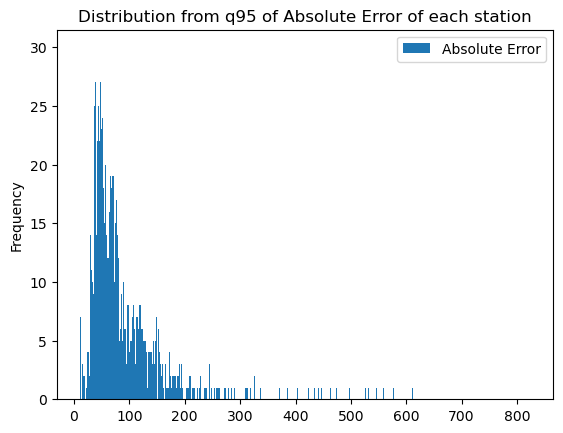

In [211]:
q = 0.95
abs_error = torch.abs(Preds - Y_true)
#mask = (abs_error> torch.quantile(abs_error, q))
mask = (abs_error> torch.quantile(abs_error, q,axis=0))

masked_previous,masked_Preds,masked_True = get_masked_previous_preds_true(mask,Preds,Y_true)


dic_metric = evaluate_metrics(Preds,Y_true,metrics=['mse','mae','mape','mase'], alpha = None, type_calib = None,dic_metric = {})
print('Metrics all points: ')
display(dic_metric)


dic_metric = evaluate_metrics(masked_Preds,masked_True,metrics=['mse','mae','mape','mase'], alpha = None, type_calib = None,dic_metric = {},previous=masked_previous)
print('Metrics tail q95:')
display(dic_metric)
pd.DataFrame({'Absolute Error': abs_error[mask]}).plot.hist(bins=1000,title = f'Distribution from q{int(q*100)} of Absolute Error of each station')

## Analysis Dates et Stations concernées:

<Axes: >

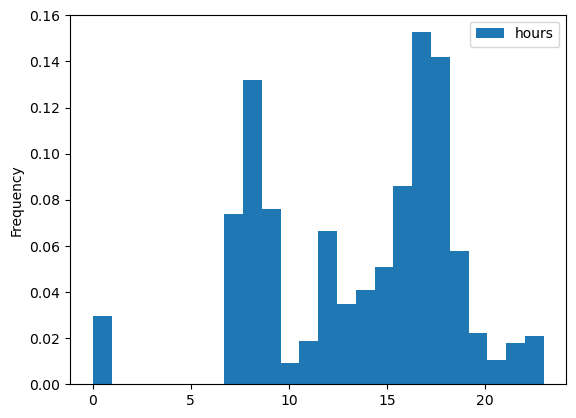

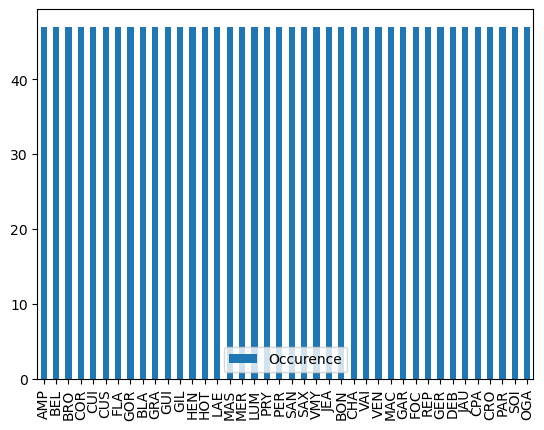

In [212]:
dates = ds.tensor_limits_keeper.df_verif_test.iloc[:,-1].reset_index(drop=True)
list_hour,occ_stations = [],{}
for station_i in range(mask.size(1)):
    dates_i = dates[pd.Series(mask[:,station_i,0])]
    list_hour+=list(dates_i.dt.hour.values)
    occ_stations[ds.spatial_unit[station_i]] = [len(dates_i)]

pd.DataFrame({'hours':list_hour}).plot.hist(bins=24,density=True)
pd.DataFrame(occ_stations).transpose().rename(columns = {0:'Occurence'}).sort_values('Occurence',ascending=False).plot.bar()

## Calculate Error relative to a statistics:

<Axes: title={'center': 'Distribution of q0.95 of absolute error relative to std by (weekday, hour, minute) of each station'}, ylabel='Frequency'>

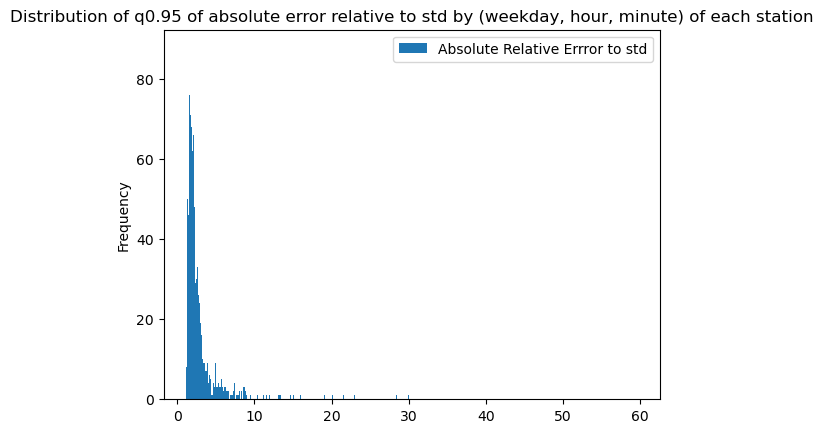

In [279]:
q = 0.95
calendar_group = ['weekday','hour','minute']

# Abs Errors: 
abs_errors = pd.DataFrame(abs(Preds-Y_true).squeeze())
abs_errors.index = dates

# Std of Volume: 
#=== replace moments when std = '0' by '1'. Correspond to night when metro is closed.
df_raw_volume = pd.DataFrame(ds.raw_values)
df_raw_volume.index = ds.df_dates.iloc[:,-1]
df_raw_volume[~df_raw_volume.index.isin(ds.invalid_dates)]

std_tab = df_raw_volume.groupby([getattr(df_raw_volume.index,calendar_i) for calendar_i in calendar_group]).std()
std_tab.index.names = calendar_group
std_tab[std_tab == 0] = 1  

nb_occurrence = df_raw_volume.groupby([getattr(df_raw_volume.index,calendar_i) for calendar_i in calendar_group]).count().iloc[:,0]
nb_occurrence.index.names = calendar_group
#display(std_tab)
#display(nb_occurrence)



# Multi_index abs_errors with hour/minutes: 
calendar_group_bis = ['date'] + calendar_group
tuples_h_m = list(zip(*[getattr(abs_errors.index,calendar_i) for calendar_i in calendar_group_bis]))
multi_index = pd.MultiIndex.from_tuples(tuples_h_m,names = calendar_group_bis)
abs_errors.index = multi_index

# Dividing abs_errros by the associated std: 
index_std = abs_errors.index.droplevel("date")
std_aligned = std_tab.loc[index_std]

normalized_errors = abs_errors.values / std_aligned.values
abs_errors_normalized = pd.DataFrame(normalized_errors, index=abs_errors.index, columns=abs_errors.columns)


# Distribution of errors:
mask_df = abs_errors_normalized>abs_errors_normalized.quantile(q)
masked_error = abs_errors_normalized[mask_df]
np_masked_error = masked_error.values.reshape(-1)
np_masked_error = np_masked_error[~np.isnan(np_masked_error)]
pd.DataFrame({f"Absolute Relative Errror to std":np_masked_error}).plot.hist(bins= 1000,title = f"Distribution of q{q} of absolute error relative to std by ({', '.join(calendar_group)}) of each station")

<Axes: >

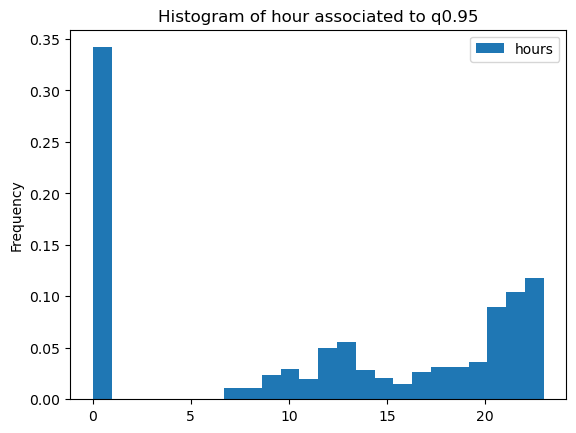

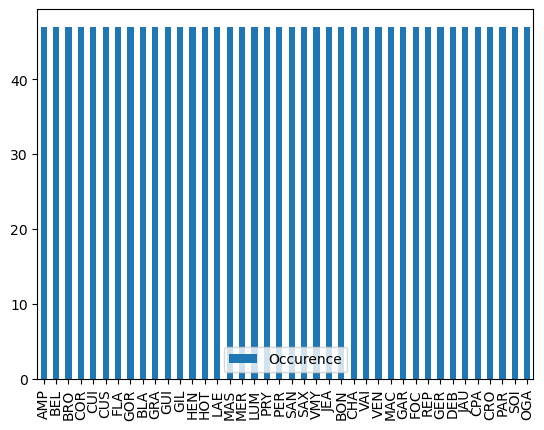

In [274]:
list_hour=[]
occ_stations = pd.DataFrame()
for c in masked_error.columns:
    list_hour_i = list(masked_error[c].reset_index().dropna().hour.values)
    list_hour+=list_hour_i
    occ_stations[ds.spatial_unit[c]] = [len(list_hour_i)]
pd.DataFrame({'hours':list_hour}).plot.hist(bins=24,density=True,title = f'Histogram of hour associated to q{q}')
pd.DataFrame(occ_stations).transpose().rename(columns = {0:'Occurence'}).sort_values('Occurence',ascending=False).plot.bar()

In [275]:
mask_bool = torch.Tensor(mask_df.to_numpy()).bool()
masked_previous,masked_Preds,masked_True = get_masked_previous_preds_true(mask_bool,Preds,Y_true)
dic_metric = evaluate_metrics(masked_Preds,masked_True,metrics=['mse','mae','mape','mase'], alpha = None, type_calib = None,dic_metric = {},previous=masked_previous)
print('Metrics tail q95:')
display(dic_metric)

Metrics tail q95:


{'mse': 7615.734375,
 'mae': 44.30959701538086,
 'mape': 195.14393615722656,
 'mase': 1.0868818759918213}

## Load Metrics on each fold:

In [ ]:
L_Apps = ['Apple_Video','Google_Play_Store','Google_Maps','Web_Clothes','Uber', 'Twitter',
        'Microsoft_Mail', 'Microsoft_Store', 'Apple_Music', 'Microsoft_Office', 'Pokemon_GO', 'Clash_of_Clans', 'Yahoo_Mail', 'PlayStation',
        'Wikipedia', 'Apple_Web_Services', 'Pinterest', 'Web_Ads', 'Google_Mail', 'Google_Meet',
        'Apple_Siri', 'Web_Adult', 'Spotify', 'Deezer', 'Waze', 'Web_Games', 'Apple_App_Store', 'Microsoft_Skydrive', 'Google_Docs', 'Microsoft_Web_Services',
        'Molotov', 'YouTube', 'Apple_iTunes', 'Apple_iMessage', 'DailyMotion', 'Netflix', 'Web_Transportation',
        'Web_Downloads', 'SoundCloud', 'TeamViewer', 'Google_Web_Services', 'Facebook', 'EA_Games', 'Tor', 'Amazon_Web_Services',
        'Web_e-Commerce', 'Telegram', 'Apple_Mail','Dropbox', 'Web_Food', 'Apple_iCloud', 'Skype', 'Facebook_Messenger', 'Twitch', 'Microsoft_Azure',
        'Instagram', 'Facebook_Live', 'Web_Streaming', 'Orange_TV', 'Periscope', 'Snapchat' ,'Web_Finance' ,'WhatsApp', 'Web_Weather','Google_Drive','LinkedIn','Yahoo','Fortnite']


def get_df_results(trial_id,model_args,L_Apps,split_key = 'eps100_'):
    df = pd.DataFrame(columns = ['mse','mae','mape','fold','id','trial_num'])
    for app in L_Apps:
        best_model_names = [name for name in model_args['model'].keys() if (f"{trial_id}_{app}_f" in name) or (f"{trial_id}_{app}_1_f" in name) or (f"{trial_id}_{app}_2_f" in name)]

        if len(best_model_names)>5:
            print(best_model_names)
            best_model_names = best_model_names[:5]

        for k,selected_model_name in enumerate(best_model_names):
            model_metrics = model_args['model'][selected_model_name]['performance']['test_metrics']
            app_num = best_model_names[0].split(split_key)[-1].split('_f')[0]
            if (not '_1' in app_num ) and (not '_2' in app_num):
                app_num = app_num+ '_1'
            name_id = '_'.join(app_num.split('_')[:-1])
            trial_num = app_num.split('_')[-1]

            df.loc[len(df)] = [model_metrics['mse'],model_metrics['mae'],model_metrics['mape'],k,name_id,trial_num]
    return df 



In [75]:
folder_name = 're_validation_epsilon100'
save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100'

df1 = get_df_results(trial_id,model_args,L_Apps)

folder_name = 're_validation'
save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100'

df2 = get_df_results(trial_id,model_args,L_Apps)
df = pd.concat([df1,df2])
df.head()

['subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_f0', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_f1', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_f2', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_f3', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_fcomplete_dataset', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_2_f0', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_2_f1', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_2_f2', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_2_f3', 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100_Apple_Video_2_fcomplete_dataset']


,mse,mae,mape,fold,id,trial_num
0,1365.452881,21.565752,43.349380,0,Apple_Video,2
1,1329.773315,21.960958,36.967972,1,Apple_Video,2
2,1264.973877,20.838892,30.041185,2,Apple_Video,2
3,1233.327148,20.747341,29.113092,3,Apple_Video,2
4,1296.285156,20.662750,28.951359,4,Apple_Video,2


## Idem pour subway-in/subway-out. Cette fois ci pas de 'NetMob'. juste plus de trial:

In [151]:
import re 
folder_name = 'tmps'
save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'
df = pd.DataFrame(columns = ['mse','mae','mape','mase','fold','trial_num'])
model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))
pattern = re.compile(rf"{trial_id}_\d_")
best_model_names = [name for name in model_args['model'].keys() if pattern.search(name)]

for selected_model_name in best_model_names:
    model_metrics = model_args['model'][selected_model_name]['performance']['test_metrics']
    trial_id = selected_model_name.split('_')[-2]
    if trial_id == 'fcomplete':
        trial_id = selected_model_name.split('_')[-3]
    fold_k = selected_model_name[-1]
    if fold_k == 't':
        fold_k = 4

    df.loc[len(df)] = [model_metrics['mse'],model_metrics['mae'],model_metrics['mape'],model_metrics['mase'],fold_k,trial_id]
df['id'] = 'subway-out'
df.head()

,mse,mae,mape,mase,fold,trial_num,id
0,1342.340454,20.975252,37.625240,0.738445,0,1,subway-out
1,1304.706909,21.791286,36.066635,0.721885,1,1,subway-out
2,1279.721680,20.709536,28.272924,0.655702,2,1,subway-out
3,1144.910278,19.843769,27.477470,0.617334,3,1,subway-out
4,1277.019531,20.500704,28.726255,0.640019,4,1,subway-out


In [144]:
import pandas as pd
import numpy as np 
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, show, output_file, save,output_notebook
from bokeh.models import ColumnDataSource, Toggle, CustomJS,HoverTool, Legend
from bokeh.layouts import layout,row,column


def plot_boxplot_on_metric(df,metric_i='mse',save_path=f"MSE_distribution_per_app_and_per_fold.html"):
    sdf = df.groupby("id")[metric_i].mean().sort_values()
    sdf_ids = sdf.index.tolist()

    if not 'fold_str' in df.columns: 
        df["fold_str"] = df["fold"].astype(str)

    grp = df.groupby("id")[metric_i]
    q1 = grp.quantile(0.25)
    q2 = grp.quantile(0.50)
    q3 = grp.quantile(0.75)
    mn = grp.min()
    mx = grp.max()
    stats = pd.DataFrame({
        "id": q1.index,
        "min_v": mn.values,
        "q1": q1.values,
        "median_v": q2.values,
        "q3": q3.values,
        "max_v": mx.values
    })
    source_box = ColumnDataSource(stats)
    source_points = ColumnDataSource(df)

    sdf = df.groupby("id")[metric_i].mean().sort_values()
    sdf_ids = sdf.index.tolist()

    p = figure(
        x_range=sdf_ids, #sorted(df["id"].unique()),
        width=1200, height=400,
        title=f"{metric_i} distribution per app and per folds"
    )
    box_width = 0.2

    p.segment("id","max_v","id","q3", source=source_box, line_width=1,line_color = 'black')
    p.segment("id","min_v","id","q1", source=source_box, line_width=1,line_color = 'black')
    p.vbar("id", box_width, "median_v", "q3", source=source_box, line_width=2,fill_color = 'grey',fill_alpha = 0.3,line_color = 'black')
    p.vbar("id", box_width, "q1", "median_v", source=source_box, line_width=2,fill_color = 'grey',fill_alpha = 0.3,line_color = 'black')
    #p.rect("id","median_v", box_width, 0, source=source_box)

    palette = Category10[len(df["fold_str"].unique())]
    p.circle(
        x="id", y=metric_i,
        source=source_points,
        size=7,
        line_color="black",
        fill_color=factor_cmap("fold_str", palette=palette, factors=df["fold_str"].unique()),
        legend_group="fold_str"
    )

    p.xaxis.axis_label = "App"
    p.yaxis.axis_label = metric_i
    p.xaxis.major_label_orientation = np.pi/2
    p.legend.title = "Fold"
    output_notebook()
    show(p)

    if save_path is not None:
        output_file(save_path)
        save(p)


if False: 
    #save_path=f"MSE_distribution_per_app_and_per_fold.html"
    save_path = f"MASE_distribution_per_app_and_per_fold.html"
    metric_i = 'mase'
    plot_boxplot_on_metric(csv_with_mase,metric_i,save_path)

    save_path = f"MAE_distribution_per_app_and_per_fold.html"
    metric_i = 'mae'
    plot_boxplot_on_metric(csv_with_mase,metric_i,save_path)

    save_path = f"MSE_distribution_per_app_and_per_fold.html"
    metric_i = 'mse'
    plot_boxplot_on_metric(csv_with_mase,metric_i,save_path)
if True:
    agg_metrics = df.groupby(['fold']).agg(mse=('mse','mean'),mae=('mae','mean'),mase=('mase','mean'),mape=('mape','mean'))
    
    for metric_i in ['mase','mae','mse']:
        df['fold_str'] = df['fold'].apply(lambda x : f"{x}. mean {metric_i.upper()}: {agg_metrics.loc[x,metric_i]}")
        plot_boxplot_on_metric(df,metric_i,f"{metric_i.upper()}_distribution_on_SUBWAY_OUT_per_fold.html")

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [ ]:
# Init 

if False:
    folder_name = 're_validation_epsilon100'

if True:
    folder_name = 're_validation'
    
save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271NETMOB_eps100'


pandas_total_results = pd.DataFrame()
for app_ind,app in enumerate(L_Apps):
    print('avancement: ',(app_ind+1)/len(L_Apps))
    best_model_names = [name for name in model_args['model'].keys() if (f"{trial_id}_{app}_f" in name) or (f"{trial_id}_{app}_1_f" in name) or (f"{trial_id}_{app}_2_f" in name)]
    if len(best_model_names)>5:
        best_model_names=best_model_names[:5]

    ## Load datasets: 
    # Load Args 
    # Use information from first fold to get the inputs (which app, which train/valid/test prop...):
    args_0 = model_args['model'][best_model_names[0]]['args']
    args_0 = Namespace(**args_0)
    args_with_contextual,K_subway_ds = get_multi_ds(args_0.model_name, args_0.dataset_names,args_0.dataset_for_coverage,args_init = args_0,fold_to_evaluate = np.arange(args_0.K_fold))
    # ...
    ## ====

    # With the already load ds, load now the trained model. And ds is ready for the evaluation:
    for k_fold,model_fold_i in enumerate(best_model_names):
        # Load trained param: 
        ds = K_subway_ds[k_fold]
        #selected_model_path = f"{current_path}/{save_path}/{model_fold_i}.pkl"
        
        # Model :
        trainer = load_trained_model(model_args,ds,model_fold_i,folder_name)

        # get metrics : 
        dic_pred_metrics = get_metrics_from_test(trainer,ds,metric_list = ['mse','mae','mape','mase'])

        pd_local_results = pd.DataFrame(dict(mse = [dic_pred_metrics['mse']],mase = [dic_pred_metrics['mase']],mae = [dic_pred_metrics['mae']], mape = [dic_pred_metrics['mape']],
                                            fold = [k_fold], id = [app], trial_num = [2] if 'eps' in folder_name else [1]))
        pandas_total_results = pd.concat([pandas_total_results,pd_local_results])
       


Training and Hyper-parameter tuning with Ray is not possible
avancement:  0.014705882352941176
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
nb subway_in invalid dates:  776
Netmob_T.size():  torch.Size([7392, 40])
vision_input_type POIs
vision_model_name None
2821 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481
Considered Spatial-Unit:  Index(['AMP', 'BEL', 'BRO', 'COR', 'CUI', 'CUS', 'FLA', 'GOR', 'BLA', 'GRA',
       'GUI',

KeyboardInterrupt: 

In [73]:
folder_name = ''
save_path = f'save/K_fold_validation/training_with_HP_tuning/{folder_name}/best_models'
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271_f0'
model_args = pickle.load(open(f'{current_path}/{save_path}/model_args.pkl','rb'))
args = model_args['model'][trial_id]['args']

In [ ]:
csv_with_mase = pd.concat([pandas_total_results,pandas_total_results_2])
csv_with_mase

In [ ]:
#csv_with_mase.to_csv('training_netmob_metric_tabs_concat.csv')
#pandas_total_results.to_csv('training_netmob_metric_tabs_1.csv')
#pandas_total_results.to_csv('training_netmob_metric_tabs_2.csv')

## Acceder à la config originelle d'un hp tuning : 

In [33]:
import pickle 
import sys
import os
import pandas as pd 

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

save_path = f'save/K_fold_validation/training_with_HP_tuning/best_models'
model_args = pickle.load(open(f'{working_dir}/{save_path}/model_args.pkl','rb'))

trial_ids = ['subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271',
             'subway_in_subway_out_STGCN_MSELoss_2025_03_29_00_17_68381'
]

for trial_id in trial_ids: 
    print('\nTrial id: ',trial_id)
    args = model_args['model'][f"{trial_id}_f0"]['args']
    print('epochs: ',args['epochs'],' lr: ',args['lr'],' wd: ',args['weight_decay'],' dropout: ',args['dropout'])
    if ('scheduler' in args.keys()) and (args['scheduler'] is not None):
        print('Scheduler: milestone: ',args['torch_scheduler_milestone'],
              ' torch_scheduler_gamma: ',args['torch_scheduler_gamma'],
              ' torch_scheduler_lr_start_factor: ',args['torch_scheduler_lr_start_factor'])
    else:
        print('Scheduler: ',None)




Trial id:  subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271
epochs:  100  lr:  0.00105  wd:  0.0188896655584368  dropout:  0.271795372610271
Scheduler: milestone:  28.0  torch_scheduler_gamma:  0.9958348861339396  torch_scheduler_lr_start_factor:  0.8809942312067847

Trial id:  subway_in_subway_out_STGCN_MSELoss_2025_03_29_00_17_68381
epochs:  500  lr:  0.00058  wd:  0.0413499097011521  dropout:  0.2171486868627564
Scheduler:  None


## Acceder aux train/valid loss d'une K-fold validation :

In [65]:
import sys
import os
import pandas as pd 

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)
    
from plotting.TS_analysis import plot_TS


save_path = f'save/K_fold_validation/training_with_HP_tuning'
trial_id_100 = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'
trial_id_500 = 'subway_in_subway_out_STGCN_MSELoss_2025_03_29_00_17_68381'
trial_id_500_scheduler = 'subway_in_subway_out_STGCN_MSELoss_2025_03_30_03_10_83808'

df_losses100 = pd.read_csv(f"{current_path}/{save_path}/Losses_{trial_id_100}.csv",index_col = 0)
df_losses500 = pd.read_csv(f"{current_path}/{save_path}/Losses_{trial_id_500}.csv",index_col = 0)
df_losses500_scheduler = pd.read_csv(f"{current_path}/{save_path}/Losses_{trial_id_500_scheduler}.csv",index_col = 0)

plot_TS(df_losses100,width=800,height=400,bool_show=True,title=f"Losses on subway-in/subway-out  HP 100 epochs",scatter = False,x_datetime = False)
plot_TS(df_losses500,width=800,height=400,bool_show=True,title=f"Losses on subway-in/subway-out  HP 500 epochs",scatter = False,x_datetime = False)
plot_TS(df_losses500_scheduler,width=800,height=400,bool_show=True,title=f"Losses on subway-in/subway-out HP 500 epochs + scheduler",scatter = False,x_datetime = False)


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

figure(id='p4877', ...)

## Etude de stabilité des entrainements:

In [6]:
current_path

'/home/rrochas/prediction-validation'

In [59]:
import pickle 
import sys
import os
import pandas as pd 

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

save_path = f'save/K_fold_validation/training_with_HP_tuning/tmps'
model_args = pickle.load(open(f'{current_path}/{save_path}/best_models/model_args.pkl','rb'))
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'

# Get Loss of each trial, each fold, valid and train: 
df_losses = pd.DataFrame()
for k in range(1,11):
    df_losses_i = pd.read_csv(f"{current_path}/{save_path}/Losses_{trial_id}_{k}.csv",index_col = 0)
    df_losses_i = df_losses_i.rename(columns = {c:f"trial_{k}_{c}" for c in df_losses_i.columns})
    df_losses = pd.concat([df_losses,df_losses_i],axis=1)
# ...


# Filter only 'valid' loss, plot valid to control stability: 
df_mean_std = pd.DataFrame()
for k in range(5):
    c_valid_trials = [c for c in df_losses.columns if f"f{k}_valid" in c]
    mean_i = df_losses[c_valid_trials].mean(axis=1)
    std_i =  df_losses[c_valid_trials].std(axis=1)
    legend_mean_i,legend_std_i = std_i.values[-1],mean_i.values[-1]

    df_mean_std_fold_k = pd.DataFrame({f"fold{k}_mean":mean_i,
                f"fold{k}_std":std_i,
                })
    df_mean_std = pd.concat([df_mean_std,df_mean_std_fold_k],axis=1)

In [62]:

from bokeh.io import output_notebook, show
from bokeh.plotting import figure,output_file,save
from bokeh.palettes import Category10
from bokeh.models import Legend


# Active l'affichage des graphiques dans le notebook (ou à enlever si utilisation en script)
output_notebook()

p = figure(
    title="Validation loss stability through 10 training",
    x_axis_label="epochs",
    y_axis_label="MSE Loss",
    width = 1000,
)

legend_items = []

# Boucle sur les 5 folds
for k in range(5):
    # Calcul de la légende personnalisée
    legend_mean_i = df_mean_std[f"fold{k}_mean"].iloc[-1]
    legend_std_i  = df_mean_std[f"fold{k}_std"].iloc[-1]
    legend_k = f"\nfold: {k}. Statistics on last value: \nmean = {'{:.2e}'.format(legend_mean_i)}, std = {'{:.2e}'.format(legend_std_i)}\n std/mean : {'{:.2e}'.format(legend_std_i/legend_mean_i)} "
   
    
    # Tracé de la ligne (moyenne)
    line_renderer = p.line(
        x=df_mean_std.index, 
        y=df_mean_std[f"fold{k}_mean"], 
        line_color=Category10[5][k-1]
    )
    
    # Zone +/- std
    varea_renderer = p.varea(
        x=df_mean_std.index,
        y1=df_mean_std[f"fold{k}_mean"] - df_mean_std[f"fold{k}_std"],
        y2=df_mean_std[f"fold{k}_mean"] + df_mean_std[f"fold{k}_std"],
        fill_color=Category10[5][k-1],
        fill_alpha=0.2
    )
    
    # Regroupement pour la légende interactive
    legend_items.append((legend_k, [line_renderer, varea_renderer]))

# Création d'une légende "en dehors" de la zone de tracé
legend = Legend(items=legend_items, location='center')
p.add_layout(legend, 'right')

# Active le click sur la légende pour hide/show les courbes
legend.click_policy = "hide"

show(p)


output_file(f"training_stability_mean_std_validation.html")
save(p)

Loading BokehJS ...

'/home/rrochas/prediction-validation/training_stability_mean_std_validation.html'